# Sector Allocation

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we minimize the variance (risk) of the portfolio given that the prescribed level of expected return is attained. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

The stock market comprises different sectors (Technology, Financial Services, Healthcare, etc.), industry groups, industries, and sub-industries and one often wants to limit exposure to each of them. In order to diversify investment risks across different industries, or to comply with regulatory requirements, one often needs to add *sector allocation constraints* to the basic model to limit

* the number of open positions and
* the total investment

in each sector.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas gurobipy_pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$
- $M$: set of sectors. We use the 11 sectors in the [Global Industry Classification Standard (GICS)](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard) classification.

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

We also import some data that contains the market capitalization and sector according to the GICS hierarchy for each of the stocks. We will need the total market capitalization and relative weight of each sector in the index.

In [5]:
# Import stock data
data = pd.read_pickle("stock_data.pkl")

# Display sector data
sectors = (
    data[["Sector", "MarketCap"]].groupby(by=["Sector"]).aggregate(["sum", "count"])
)
sectors.columns = ["MarketCap", "Number"]
sectors["Weight"] = sectors["MarketCap"] / sectors["MarketCap"].sum()
sectors.sort_values("MarketCap", ascending=False)

MarketCap  Number    Weight
Sector                                                  
Technology              12715607901184      65  0.286058
Communication Services   6054451107840      18  0.136205
Financial Services       5588576733184      64  0.125724
Healthcare               5272300330496      60  0.118609
Consumer Cyclical        4588151685632      53  0.103218
Industrials              3305283061760      67  0.074358
Consumer Defensive       2780607703040      34  0.062554
Energy                   1569043430400      23  0.035298
Real Estate               931872515072      29  0.020964
Utilities                 868188347904      29  0.019531
Basic Materials           777054908928      20  0.017481

For example, 65 stocks from our set belong to the Technology sector, which accounts for 28.6% of the total market capitalization.

For reference, we will compute the _market portfolio_ as the portfolio that allocates into all stocks relative to the stocks' market capitalization.

In [6]:
x_market = data["MarketCap"] / data["MarketCap"].sum()
data_market = {
    "Variance": x_market @ Sigma @ x_market,
    "Expected return": x_market @ mu,
}
print(data_market)

{'Variance': np.float64(4.673079099420153), 'Expected return': np.float64(0.28157962440870105)}


## Formulation
The model minimizes the variance of the portfolio subject to

* the portfolio matches the expected return of the market portfolio,
* the size of each position does not fall below a certain level,
* the total investment in each sector lies between specified lower and upper bounds,
* the number of positions in each sector does not exceed a specified number.

Mathematically, this results in a convex quadratic mixed-integer optimization problem.

### Model Parameters

We use the following parameters:

- $\bar\mu$: required expected portfolio return
- $\ell>0$: lower bound on position size
- $K_m$: maximal number of stocks in the portfolio from sector $m$.
- $\ell_m, u_m$: lower and upper bounds on the weight of sector $m$ in the portfolio. In this notebook, we will choose those bounds as a +/- 10% envelope around the sector weight in the S&P 500: That is, we choose $\ell_m = (1-\delta)w_m, u_m = (1+\delta)w_m$, where $w_m$ is the weight of sector $m$ in the index.

In [7]:
# Values for the model parameters:
r = data_market["Expected return"]  # Required return
l = 0.00001  # Minimal position size
K = 3  # Maximal number of stocks per sector
delta = 0.1  #  bound on the relative deviation from sector weight

### Decision Variables
We need two sets of decision variables:

1. The proportions of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

2. Binary variables $b_i$ indicating whether or not asset $i$ is held. If $b_i$ is 0, the holding $x_i$ is also 0; otherwise if $b_i$ is 1, the investor holds asset $i$ (that is, $x_i \geq \ell$).

### Variable Bounds

Each position must be between 0 and 1; this prevents leverage and short-selling:

\begin{equation*}
0\leq x_i\leq 1 \; , \;  i \in S
\end{equation*}


The $b_i$ must be binary:

\begin{equation*}
b_i \in \{0,1\} \; , \; i \in S
\end{equation*}

We will model this using the [gurobipy-pandas](https://gurobipy-pandas.readthedocs.io/en/stable/) package. Using this, we create a  DataFrame containing the decision variables as columns.

In [8]:
# Create an empty optimization model
m = gp.Model()

# Add variables to model, align with data
df_model = (
    # x[i] denotes the proportion invested in stock i
    data.gppd.add_vars(m, name="x", ub=1)
    # b[i]=1 if stock i is held, and b[i]=0 otherwise
    .gppd.add_vars(m, name="b", vtype=gp.GRB.BINARY).drop(
        "Risk", axis=1
    )  # Not needed here
)

# A quick look at this DataFrame:
m.update()
df_model

MarketCap                  Sector                      Name  \
MSFT   3004349808640              Technology     Microsoft Corporation   
AAPL   2893580337152              Technology                Apple Inc.   
AMZN   1750173089792       Consumer Cyclical          Amazon.com, Inc.   
NVDA   1684540096512              Technology        NVIDIA Corporation   
GOOGL  1789200171008  Communication Services             Alphabet Inc.   
...              ...                     ...                       ...   
RL        9448713216       Consumer Cyclical  Ralph Lauren Corporation   
SEE       4919490560       Consumer Cyclical    Sealed Air Corporation   
DVA      10014481408              Healthcare               DaVita Inc.   
ALK       4465086464             Industrials    Alaska Air Group, Inc.   
MHK       6813997568       Consumer Cyclical   Mohawk Industries, Inc.   

                           x                      b  
MSFT    <gurobi.Var x[MSFT]>   <gurobi.Var b[MSFT]>  
AAPL    <gurobi.Var x[AAPL]>   <gurobi.Var b[AAPL]>  
AMZN    <gurobi.Var x[AMZN]>   <gurobi.Var b[AMZN]>  
NVDA    <gurobi.Var x[NVDA]>   <gurobi.Var b[NVDA]>  
GOOGL  <gurobi.Var x[GOOGL]>  <gurobi.Var b[GOOGL]>  
...                      ...                    ...  
RL        <gurobi.Var x[RL]>     <gurobi.Var b[RL]>  
SEE      <gurobi.Var x[SEE]>    <gurobi.Var b[SEE]>  
DVA      <gurobi.Var x[DVA]>    <gurobi.Var b[DVA]>  
ALK      <gurobi.Var x[ALK]>    <gurobi.Var b[ALK]>  
MHK      <gurobi.Var x[MHK]>    <gurobi.Var b[MHK]>  

[462 rows x 5 columns]

###  Constraints
The budget constraint ensures that all capital is invested:

\begin{equation*}
\sum_{i \in S} x_i =1
\end{equation*}

The expected return of the portfolio must be at least $\bar\mu$:

\begin{equation*}
\mu^\top x \geq \bar\mu
\end{equation*}

We use functionality from pandas to create those constraints.  Note that this ensures that the indices of `df_model` and `mu` are aligned.

In [9]:
%%capture
# Budget constraint: all investments sum up to 1
m.addConstr(df_model["x"].sum() == 1, name="Budget_Constraint")

# Lower bound on expected return
m.addConstr(mu @ df_model["x"] >= r, "Required_Return")

From the bounds alone, $x$ can take any value between $0$ and $1$. To enforce the minimal position size, we need the binary variables $b$ and the following sets of discrete constraints:

Ensure that $x_i = 0$ if $b_i = 0$:

\begin{equation*}
x_i \leq b_i \; , \; i \in S\tag{1}
\end{equation*}

Note that since $x_i$ has an upper bound of 1, the above constraint is non-restrictive if $b_i = 1$.

Ensure a minimal position size of $\ell$ if asset $i$ is traded:

\begin{equation*}
x_i \geq \ell b_i \; , \; i \in S\tag{2}
\end{equation*}

Hence $b_i = 1$ implies $x_i \geq \ell$. Additionally, if $b_i = 0$, the above constraint is non-restrictive since $x_i$ has a lower bound of 0.

To add these constraints to the model, we use [gurobipy-pandas functionality](https://gurobipy-pandas.readthedocs.io/en/stable/usage.html#adding-constraints).

In [10]:
%%capture
# Force x to 0 if not traded; see formula (1) above
# We use a gurobipy-pandas DataFrame accessor that takes the constraint as a string with column labels
df_model.gppd.add_constrs(m, "x <= b", name="Indicator")

# Minimal position; see formula (2) above
# We use a gurobipy-pandas function that takes the model, the left-hand side, sense, and right-hand side
gppd.add_constrs(
    m,
    df_model["x"],
    ">",
    l * df_model["b"],
    name="Minimal_Position",
)

#### Allocation constraints by sector

The weight of all stocks in sector $m$ must be within the prescribed bounds:

\begin{equation*}
\ell_m \leq \sum_{i\in m} x_i \leq u_m \; , \; m \in M\; , \tag{3}
\end{equation*}

where $\ell_m = (1-\delta)w_m$ and $u_m = (1+\delta)w_m$.

Likewise, the number of stocks in sector $m$ must not exceed $K_m$. We use the binary variables $b_i$ to count positions.

\begin{equation*}
\sum_{i\in m} b_i \leq K_m \; , \; m \in M \tag{4}
\end{equation*}

The DataFrame's `groupby` method can be used to conveniently create sums over all stocks within the same sector:

In [11]:
# Lower and upper bounds on position size per sector; see formula (3) above
sector_weight_ub = gppd.add_constrs(
    m,
    df_model.groupby("Sector")["x"].sum(),
    "<",
    sectors["Weight"] * (1 + delta),
    name="Sector_Weight_UB",
)
sector_weight_lb = gppd.add_constrs(
    m,
    df_model.groupby("Sector")["x"].sum(),
    ">",
    sectors["Weight"] * (1 - delta),
    name="Sector_Weight_LB",
)

# Upper bound on the number of positions per sector; see formula (4) above
sector_cardinality = gppd.add_constrs(
    m,
    df_model.groupby("Sector")["b"].sum(),
    "<",
    K,
    name="Sector_Cardinality",
)

###  Objective Function
The objective is to minimize the risk of the portfolio, which is measured by its variance:

\begin{equation*}
\min_x x^\top \Sigma x
\end{equation*}

In [12]:
# Define objective function: Minimize risk
m.setObjective(df_model["x"] @ Sigma @ df_model["x"], gp.GRB.MINIMIZE)

We now solve the optimization problem:

In [13]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 959 rows, 924 columns and 4158 nonzeros


Model fingerprint: 0xd130e4c6


Model has 106953 quadratic objective terms


Variable types: 462 continuous, 462 integer (462 binary)


Coefficient statistics:


  Matrix range     [1e-05, 1e+00]


  Objective range  [0e+00, 0e+00]


  QObjective range [6e-03, 2e+02]


  Bounds range     [1e+00, 1e+00]


  RHS range        [2e-02, 3e+00]


Presolve time: 0.05s


Presolved: 959 rows, 924 columns, 4157 nonzeros


Presolved model has 106953 quadratic objective terms


Variable types: 462 continuous, 462 integer (462 binary)


Found heuristic solution: objective 4.2808136


Root relaxation: objective 2.599011e+00, 210 iterations, 0.01 seconds (0.01 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    2.59901    0   36    4.28081    2.59901  39.3%     -    0s


H    0     0                       2.6251831    2.59901  1.00%     -    0s


     0     0    2.59901    0   34    2.62518    2.59901  1.00%     -    0s


     0     0    2.59901    0   33    2.62518    2.59901  1.00%     -    0s


H    0     0                       2.6225600    2.59901  0.90%     -    0s


     0     0    2.59901    0   32    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     0    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


     0     2    2.59901    0   30    2.62256    2.59901  0.90%     -    0s


H   40    11                       2.6225597    2.62091  0.06%   8.1    0s


Cutting planes:


  Gomory: 1


  Cover: 3


  MIR: 2


  Flow cover: 8


Explored 53 nodes (627 simplex iterations) in 0.45 seconds (0.25 work units)


Thread count was 2 (of 2 available processors)


Solution count 4: 2.62256 2.62256 2.62518 4.28081 


Optimal solution found (tolerance 1.00e-04)


Best objective 2.622559688764e+00, best bound 2.622379368808e+00, gap 0.0069%


Display basic solution data based on the individual assets and sectors:

In [14]:
data_model1 = {
    "Variance": m.ObjVal,
    "Expected return": mu @ df_model["x"].gppd.X,
}

print(f"Variance:         {m.ObjVal:.6f}")
print(f"Expected return:  {mu @ df_model['x'].gppd.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e. >1e-5)
data["Position"] = df_model["x"].gppd.X
data[data["Position"] > 1e-5][["MarketCap", "Sector", "Position"]].sort_values(
    "Position", ascending=False
)

Variance:         2.622560
Expected return:  0.281580
Solution time:    0.46 seconds



MarketCap                  Sector  Position
MSFT  3004349808640              Technology  0.129882
LLY    667918204928              Healthcare  0.119143
PGR    106073907200      Financial Services  0.096290
BR      23238772736              Technology  0.082739
TMUS   193721221120  Communication Services  0.063901
DPZ     14603976704       Consumer Cyclical  0.054687
WM      75618992128             Industrials  0.049627
TYL     17882144768              Technology  0.044831
AZO     48049000448       Consumer Cyclical  0.037813
TTWO    27903057920  Communication Services  0.035356
NOC     66327912448             Industrials  0.031669
KR      33348851712      Consumer Defensive  0.030470
CME     73643769856      Financial Services  0.029367
KDP     43670155264      Consumer Defensive  0.024210
CTRA    18142871552                  Energy  0.023883
VZ     174259945472  Communication Services  0.023327
ED      31142295552               Utilities  0.021474
MCD    207836446720       Consumer Cyclical  0.020241
DLR     44423024640             Real Estate  0.018868
HRL     16470820864      Consumer Defensive  0.014130
MKTX     8191925760      Financial Services  0.012639
APD     49082589184         Basic Materials  0.008529
XOM    402421940224                  Energy  0.007886
NEM     38533505024         Basic Materials  0.007204
GILD    95658491904              Healthcare  0.006410
MRK    318729060352              Healthcare  0.004917
RSG     54473105408             Industrials  0.000497

In [15]:
# Display sector data
data_sectors = (
    data[data["Position"] > 1e-5].groupby("Sector")["Position"].agg(["sum", "count"])
)
data_sectors.columns = ["Weight", "Number"]
data_sectors.sort_values("Weight", ascending=False)

Weight  Number
Sector                                  
Technology              0.257452       3
Financial Services      0.138296       3
Healthcare              0.130470       3
Communication Services  0.122584       3
Consumer Cyclical       0.112741       3
Industrials             0.081793       3
Consumer Defensive      0.068810       3
Energy                  0.031768       2
Utilities               0.021474       1
Real Estate             0.018868       1
Basic Materials         0.015733       2

## Comparison with the unconstrained portfolio

For comparison purposes, we will also compute the portfolio without the sector allocation constraints:

* upper and lower bounds on the weight of each sector in the portfolio,
* upper bound on the number of bought stocks in each sector.


To compute this, we relax the right-hand sides of those constraints enough to make them non-binding.  In addition, we show the risk and return of the market porfolio that results from weighing all the of S&P500 stocks according to their market capitalization.

In [16]:
# remove sector allocation constraints by relaxing the RHSs
sector_weight_ub.gppd.set_attr("RHS", 1)
sector_weight_lb.gppd.set_attr("RHS", 0)
sector_cardinality.gppd.set_attr("RHS", 100)

m.params.OutputFlag = 0
m.optimize()

data_model2 = {
    "Variance": m.ObjVal,
    "Expected return": mu @ df_model["x"].gppd.X,
}

df_results = pd.DataFrame(
    index=["with allocation constraints", "unconstrained", "market"],
    data=[data_model1, data_model2, data_market],
)
display(df_results)

Variance  Expected return
with allocation constraints  2.622560          0.28158
unconstrained                2.344234          0.28158
market                       4.673079          0.28158

From this comparison we see the effect of enforcing our sector allocation constraints:

- In comparison with the unconstrained portfolio, the variance increases by about 15% by enforcing all sector allocation constraints.  This is the "price" we have to pay for these portfolio features.
- The optimized portfolios have greatly reduced variance in comparison with the market portfolio.

Finally we visualize the allocated investment sum for each stock being bought by either of the two optimized portfolios.

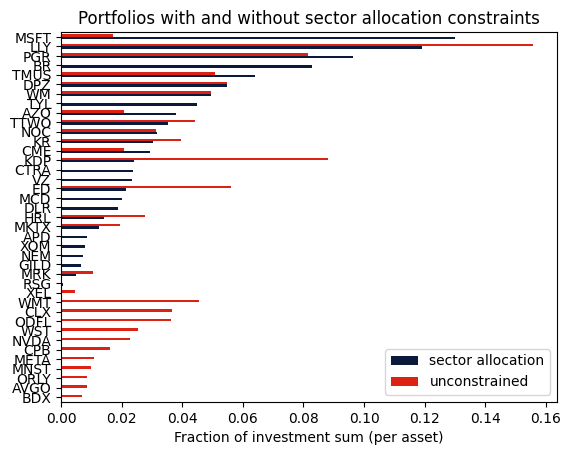

In [17]:
# retrieve solution data and store in data
data["Position unconstr"] = df_model["x"].gppd.X

mask = (data["Position"] > 1e-5) | (data["Position unconstr"] > 1e-5)
df_positions = pd.DataFrame(
    index=data[mask].index,
    data={
        "sector allocation": data["Position"],
        "unconstrained": data["Position unconstr"],
    },
).sort_values(by=["sector allocation", "unconstrained"], ascending=True)

# plot data
axs = df_positions.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum (per asset)")
plt.title("Portfolios with and without sector allocation constraints")
plt.show()

We can also compare the resulting sector allocation with the unconstrained portfolio and the market capitalization in the S&P 500 index:

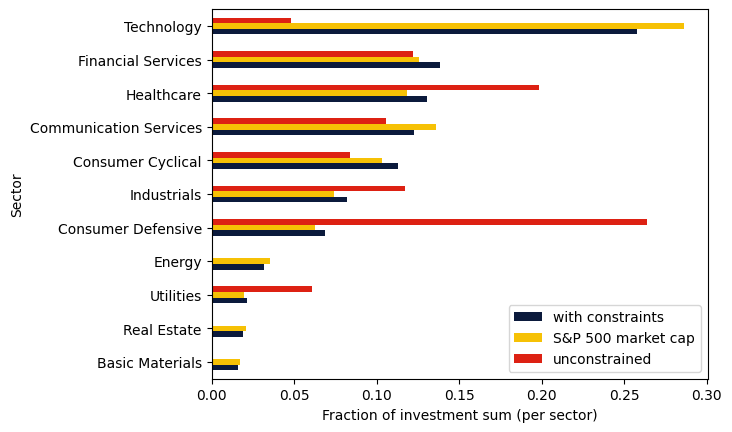

In [18]:
df_sectors = pd.DataFrame(
    index=data_sectors.index,
    data={
        "with constraints": data_sectors["Weight"],
        "S&P 500 market cap": sectors["Weight"],
        "unconstrained": data.groupby("Sector").sum()["Position unconstr"],
    },
).sort_values(by=["with constraints"], ascending=True)

axs = df_sectors.plot.barh(color=["#0b1a3c", "#f6c105", "#dd2113"])
axs.set_xlabel("Fraction of investment sum (per sector)")
plt.show()

One can see that without the allocation constraints, the resulting portfolio can be quite far from the distribution in the index. For example, in the S&P 500, the Technology sector has a weight of almost 29%, but the unconstrained portfolio almost completely avoids it due to its high variance.  With the sector allocation constraints, we maintain the diversification from the index.

## Takeaways
* Constraints on the number of assets and total investment in each sector can be incorporated into the model.
* Data from pandas DataFrames can easily be used to build an optimization model via the [gurobipy-pandas](https://github.com/Gurobi/gurobipy-pandas) package.
* Sums over subsets of the variables can be defined using the DataFrame's `groupby` method.